
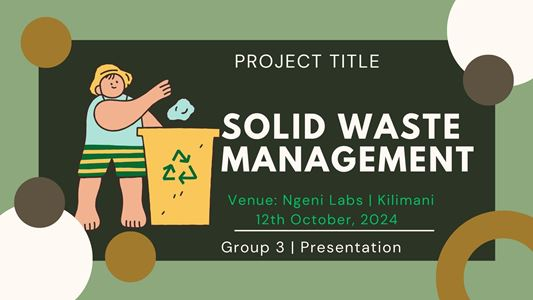

# Introduction
<hr>
Waste management involves the collection, transportation, treatment, and disposal of waste to minimize its impact on the environment and human health. It covers various waste types, including municipal solid waste, hazardous waste, industrial waste, and e-waste. The goal is to reduce waste generation and promote sustainability through recycling, reusing, and proper disposal. Key strategies include the waste hierarchy, which prioritizes prevention and recycling, and the circular economy, which focuses on maximizing the use of resources. Effective waste management is vital for sustainable development, conserving natural resources, and reducing pollution for a cleaner environment.


# Problem Statement
<hr>
At TakaTaka Solutions, waste is classified into eight categories: Plastic, metal, food organics, vegetation, miscellaneous trash, textiles, glass and paper. The manual process of sorting waste introduces errors, such as misclassifying items, leading to inefficiencies in recycling operations and increased waste sent to landfills. There is a pressing need for an automated system that can accurately classify waste images into these categories, reducing human error and improving the overall recycling rate.

# Objectives
<hr>

 - To develop an automated system that accurately classifies waste into eight categories: plastic, metal, food organics, vegetation, miscellaneous trash, textiles, glass, and paper, minimizing human errors in the sorting process.
 
 - To reduce inefficiencies in recycling operations caused by the manual misclassification of waste items, enhancing the accuracy of waste categorization.

In [1]:
# Load Python Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

from keras.models import Sequential, save_model
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
import cv2
import matplotlib.pyplot as plt
import warnings
import os
import numpy as np

warnings.filterwarnings('ignore')

In [2]:
!pip install split-folders

Defaulting to user installation because normal site-packages is not writeable


In [6]:

# Path to the directory containing all images (subdirectories)
dataset_dir = '../Solid Waste Management Modeling/RealWaste'

# Load the entire dataset
images_dataset = image_dataset_from_directory(
    dataset_dir,
    image_size=(256, 256),  # Resize images to 256x256, can be changed
    batch_size=32,          # Number of images per batch
    label_mode='int',       # Labels as integers
    seed=123,               # For reproducibility
    shuffle=True            # Shuffle dataset
)


Found 4291 files belonging to 8 classes.


# Split the Dataset into Train and Test

In [7]:
from sklearn.model_selection import train_test_split

# Split the dataset (80% for training, 20% for testing)
train_size = 0.8
total_images = images_dataset.cardinality().numpy()  # Get the total number of batches
train_batches = int(train_size * total_images)
test_batches = total_images - train_batches

# Split into training and testing datasets
X_train = images_dataset.take(train_batches)
X_test = images_dataset.skip(train_batches)


In [4]:
X_train
X_test


<_SkipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Normalization

In [8]:
# Normalization layer to scale pixel values from [0, 255] to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply normalization to both train and test datasets
X_train = X_train.map(lambda x, y: (normalization_layer(x), y))
X_test = X_test.map(lambda x, y: (normalization_layer(x), y))


In [9]:
normalization_layer

<Rescaling name=rescaling, built=True>

# Data Preprocessing (Data Augmentation)
Augment the images in train data before training the model, so the model can see more variety in the images during the training, like rotating the image,squash, shifting the image e.t.c to reduce data underfitting of the unseen data.


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

''' data augmentation '''

train_datagen = ImageDataGenerator(
    rescale=1/255, # rescale the image to the range 0 to 1
    rotation_range=40, # rotating the image by 0-40 degree
    width_shift_range=0.2, # shifting the image to the left/right up to 20%
    height_shift_range=0.2, # shifting the image to the up/down up to 20%
    shear_range=0.2, # distorted the image up to 20%
    zoom_range=0.2, # zooming the image up to 20%
    horizontal_flip=True, # flipping the image
    fill_mode='nearest') 

val_datagen = ImageDataGenerator(rescale=1/255)

# Modeling


In [11]:
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten

# create a model with sequential class
model = Sequential() 

# Layers are added sequentialy
# 1st layer: convolution has 16 filters ( 3 x 3 pixels inside).

# The power is coming from activation function. Relu is replacing null values.

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))

# 2nd layer - choose maximum value after the relu activation (2 x 2)
model.add(MaxPooling2D())

# 3rd layer, output is only 1 value, use 32 filters
model.add(Conv2D(32, (3,3), 1, activation='relu'))

# 4th layer
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# flatten the data again down
model.add(Flatten())

# convolution has 2 Dense layers
model.add(Dense(256, activation='relu')) # output is 256 values
# The final sigmoid layer, close to 0 are mountains, close to 1 is the city
# Sigmoid activation is non-linear, continuously differentiable, monotonic, and has a fixed output range. Main advantage is simple and good for classifier. 
# Sigmoid activation gives rise to a problem of “vanishing gradients” because Its output isn’t zero centered. Sigmoid activation is computationaly more expensive.
model.add(Dense(1, activation='sigmoid')) # single dense layer is the final layer, converts values between 0 and 1


model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

model.summary()
# if the layer is not trainable, there is 0 in Param column
# total params stands for the total size of our model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
hist = model.fit(X_train, epochs=10 )
hist.history

Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.1042 - loss: -12430128185344.0000
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.1092 - loss: -30582893445120.0000
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.1044 - loss: -66263032266752.0000
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.1080 - loss: -126048163332096.0000
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.1026 - loss: -223413729755136.0000
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.1065 - loss: -364027771355136.0000
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.1091 - loss: -562808353718272.0000
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.1046 - loss: -846326124249088.0000
Epoch 9/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.1071 - loss: -1217845090320384.0000
Epoch 10/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.1023 - loss: -16

{'accuracy': [0.09953703731298447,
  0.09866898506879807,
  0.0972222238779068,
  0.0989583358168602,
  0.09953703731298447,
  0.09751157462596893,
  0.09866898506879807,
  0.09780092537403107,
  0.09693287312984467,
  0.0989583358168602],
 'loss': [-15700516143104.0,
  -37268500774912.0,
  -77792343490560.0,
  -145929583722496.0,
  -249249618984960.0,
  -403645757652992.0,
  -618140081848320.0,
  -918397487415296.0,
  -1309199984230400.0,
  -1807615101239296.0]}

# Model Evaluation
After training, we evaluate the model’s performance on the test set to assess its accuracy and generalization ability.

In [47]:
loss, accuracy = model.evaluate(X_train, batch_size=32, verbose = 0)
print(f"Test Loss:, {loss}")
print(f"Test  Accuracy: {accuracy}")

Test Loss:, -2108558359396352.0
Test  Accuracy: 0.0989583358168602


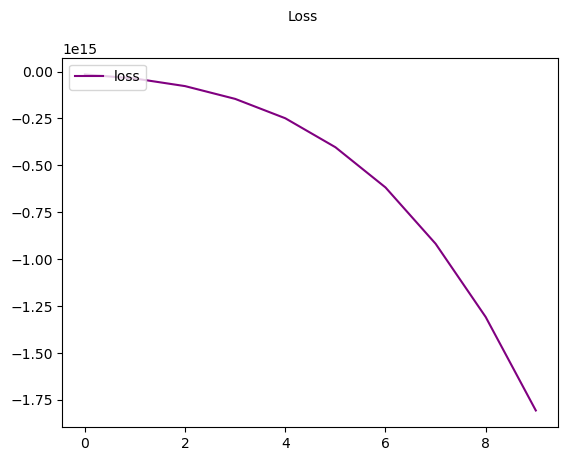

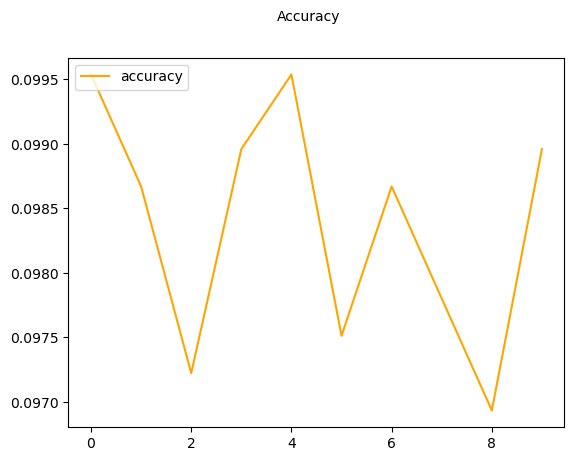

In [43]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='purple', label='loss')
# plt.plot(hist.history['val_loss'], color='red', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper left")
plt.show()


fig = plt.figure()
plt.plot(hist.history['accuracy'], color='orange', label='accuracy')
# plt.plot(hist.history['val_accuracy'], color='green', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="upper left")
plt.show()

# Prediction

In [48]:
# Test the model: read the image that is not in training
# Load the saved model

from keras.preprocessing import image
import numpy as np

from tensorflow.keras.models import load_model

loaded_model = load_model("../Solid Waste Management Modeling/trained_model.keras")

# Make predictions on new data
# For example, if you have a single image 'new_image.jpg' for prediction

# Load the image
new_image = image.load_img('../Solid Waste Management Modeling/test2.jpg', target_size=(256, 256))
new_image = image.img_to_array(new_image)
new_image = np.expand_dims(new_image, axis=0)

# Normalize the image data
new_image = new_image / 255.0

# Make prediction
prediction = loaded_model.predict(new_image)

if prediction[0][0] > 0.5:
    print("Nylon Trash")
else:
    print("Not Recognized")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Nylon Trash


In [49]:
X_pred = model.predict(X_train)

108/108 ━━━━━━━━━━━━━━━━━━━━ 65s 547ms/step


In [25]:
X_pred

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

# Save the Model

In [50]:
# Save the model
loaded_model = model.save('trained_model.keras')